In [1]:
import numpy as np
import tensorcircuit as tc
from scipy.stats import unitary_group
from opt_einsum import contract
import time

import jax
import jax.numpy as jnp
from jax import random
import optax

from src.QDT_jax import QDT, HaarSampleGeneration
from src.distance_jax import naturalDistance

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


# Clustered state

In [2]:
def cluster0Gen(n, N_train, scale, seed):
    # generate random quantum states close to |0...0>
    remains = (random.normal(random.PRNGKey(seed), shape=(N_train,2**n-1)) 
                + 1j*random.normal(random.PRNGKey(seed+1), shape=(N_train,2**n-1)))
    states = jnp.hstack((np.ones((N_train,1)), scale*remains))
    states /= jnp.tile(jnp.linalg.norm(states, axis=1).reshape((1, N_train)), (2**n, 1)).T
    return states.astype(jnp.complex64)

# Training

In [3]:
def training(model, inputs, epochs):
    '''
    training of generator in QGAN
    Inputs:
        model: QGAN model
        inputs: input states
        epochs: training epochs
    '''
    Ndata = inputs.shape[0]

    loss_hist = [] # record of training history

    states_diff = model.states_diff

    # initialize parameters
    key = random.PRNGKey(42)
    params = random.normal(key, shape=(2*model.n_tot*model.L,))

    # set optimizer and learning rate decay
    optimizer = optax.adam(learning_rate = 0.0005)
    opt_state = optimizer.init(params)

    def loss_func(params, input_tplus1, true_data):
        output = model.backwardOutput(input_tplus1, params)
        loss = naturalDistance(output, true_data)
        
        return loss

    loss_func_vg = jax.jit(jax.value_and_grad(loss_func))
    #@partial(jax.jit, static_argnums=(2, ))
    def update(params, input_tplus1, true_data, opt_state):
        loss_value, grads = loss_func_vg(params, input_tplus1, true_data)

        updates, new_opt_state = optimizer.update(grads, opt_state, params)
        new_params_t = optax.apply_updates(params, updates)

        return new_params_t, new_opt_state, loss_value

    input_tplus1 = jnp.concatenate([inputs, jnp.zeros(shape=(Ndata, 2**model.n_tot-2**model.n), 
                                                           dtype=jnp.complex64)], axis=1)
    t0 = time.time()
    for step in range(epochs):
        np.random.seed()
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[0, indices]

        params, opt_state, loss_value = update(params, input_tplus1, true_data, opt_state)
        
        if step % 100 == 0:
            print("Step {}, loss: {:.7f}, time elapsed: {:.4f} seconds".format(step, loss_value, time.time() - t0))
        
        loss_hist.append(loss_value) # record the current loss

    return params, loss_hist

In [4]:
n = 2
na = 1
L = 120
Ndata = 100
epochs = int(4e4)

states_diff = np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy')
states_diff = np.stack([states_diff[0], states_diff[-1]])

inputs = HaarSampleGeneration(Ndata, n, seed=22)

model = QDT(n, na, L)
model.set_diffusionSet(states_diff)

params, loss = training(model, inputs, epochs)

np.save('data/qdt/QDTcluster0params_n2na1L120_mmd.npy', params)
np.save('data/qdt/QDTcluster0loss_n2na1L120_mmd.npy', loss)

Step 0, loss: 0.7673177, time elapsed: 547.9974 seconds
Step 100, loss: 0.1940195, time elapsed: 549.1891 seconds
Step 200, loss: 0.2486908, time elapsed: 550.2068 seconds
Step 300, loss: 0.2512765, time elapsed: 551.1994 seconds
Step 400, loss: 0.2611692, time elapsed: 552.1854 seconds
Step 500, loss: 0.2648728, time elapsed: 553.1952 seconds
Step 600, loss: 0.2404092, time elapsed: 554.2665 seconds
Step 700, loss: 0.2747188, time elapsed: 555.4279 seconds
Step 800, loss: 0.2438238, time elapsed: 556.6640 seconds
Step 900, loss: 0.2718539, time elapsed: 557.7322 seconds
Step 1000, loss: 0.2564972, time elapsed: 558.8009 seconds
Step 1100, loss: 0.2505361, time elapsed: 559.8199 seconds
Step 1200, loss: 0.2749615, time elapsed: 560.9004 seconds
Step 1300, loss: 0.2543156, time elapsed: 561.9084 seconds
Step 1400, loss: 0.2388519, time elapsed: 562.9588 seconds
Step 1500, loss: 0.2726290, time elapsed: 563.9783 seconds
Step 1600, loss: 0.2629238, time elapsed: 564.9314 seconds
Step 1700

# Performance

## generate training and testing data

In [5]:
# sample generation
n = 2
na = 1
L = 120
Ndata = 100

inputs_tr = HaarSampleGeneration(Ndata, n, seed=22)
inputs_te = HaarSampleGeneration(Ndata, n, seed=23)

params = np.load('data/qdt/QDTcluster0params_n2na1L120_mmd.npy')

model = QDT(n, na, L)
states_tr = model.backDataGeneration(inputs_tr, params, Ndata)
states_te = model.backDataGeneration(inputs_te, params, Ndata)

np.save('data/qdt/QDTcluster0trainGen_n2na1L120_mmd.npy', states_tr)
np.save('data/qdt/QDTcluster0testGen_n2na1L120_mmd.npy', states_te)

## visualize in fidelity

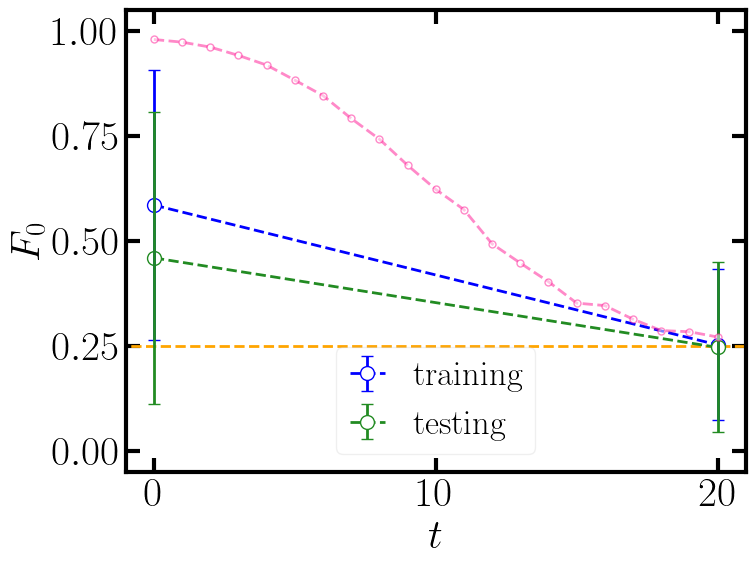

In [6]:
Ndata = 100
F0_train_qdt = np.abs(np.load('data/qdt/QDTcluster0traingen_n2na1L120_mmd.npy')[:,:,0])**2
F0_test_qdt = np.abs(np.load('data/qdt/QDTcluster0testgen_n2na1L120_mmd.npy')[:,:,0])**2
F0_diff = np.abs(np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy')[:,:,0])**2

fig, ax = plt.subplots(figsize=(8, 6))
T1 = 20
ax.errorbar([0, T1], np.mean(F0_train_qdt, axis=1), yerr=np.std(F0_train_qdt, axis=1), fmt='o--',
    lw=2, mfc='white', barsabove=True, markersize=10, c='b', capsize=4, zorder=5, label=r'$\rm training$')
ax.errorbar([0, T1], np.mean(F0_test_qdt,axis=1), yerr=np.std(F0_test_qdt, axis=1), fmt='o--',
    lw=2, mfc='white', barsabove=True, markersize=10, capsize=4, c='forestgreen', zorder=5, label=r'$\rm testing$')

ax.plot(np.arange(T1+1), np.mean(F0_diff, axis=1), 'o--', mfc='white',
    lw=2, markersize=5, c='deeppink', alpha=0.5, zorder=5)

ax.legend(fontsize=25, loc='lower center', handlelength=1, framealpha=0.3)
ax.hlines(0.25, xmin=-5, xmax=25, lw=2, ls='--', color='orange')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_xlim(-1, 21)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(3)*10)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)